In [9]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Markdown, display
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import sys
import dataset

# sys.path.append("src/")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")

# print(torch.cuda.get_device_name(0))
# sns.set()

Device: mps


### Visualization functions

In [2]:
import matplotlib.pyplot as plt

def plot_both(image1,image2):
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, recreated_image):
    print(original_image.shape)
    print(recreated_image.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),recreated_image),0)

'''
TODO: when using lab color space we have certain artefacts that do not appear when we only use RGB images

may be from normalization in the lab space or the transformation itself

entry[image][0]
'''
def visualize(entry,model,lab=False):
    image = entry['grayscale_image']
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu().squeeze(0)

    if lab:
        lab2rgb = dataset.LABtoRGB()
        rgb_image = lab2rgb(entry['image'])
        ## TODO: if here entry['image'][0:1,:,:] is used, the image is not displayed correctly
        composed_lab = torch.cat((entry['grayscale_image'],output),0)
        composed_output = lab2rgb(composed_lab)


    plot_both(rgb_image.permute(1,2,0).numpy(),composed_output.permute(1,2,0).numpy())


In [3]:

def plot_grid(images_column1, images_column2):
    '''
    Plots a 2x8 grid of rgb images, where each row corresponds to a pair of images from the two input lists.
    '''
    num_images_column1 = len(images_column1)
    num_images_column2 = len(images_column2)
    num_rows = max(num_images_column1, num_images_column2)
    
    plt.figure(figsize=(12, 8))  # Adjust figsize as needed

    for i in range(num_rows):
        # Plot images from the first column
        if i < num_images_column1:
            plt.subplot(num_rows, 2, 2*i + 1)
            plt.imshow(images_column1[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 1)')
            plt.axis('off')  # Turn off axis for better visualization
        
        # Plot images from the second column
        if i < num_images_column2:
            plt.subplot(num_rows, 2, 2*i + 2)
            plt.imshow(images_column2[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 2)')
            plt.axis('off')  # Turn off axis for better visualization

    plt.tight_layout(pad=0.1)  # Adjust spacing between subplots
    plt.show()

def get_visualization_images(indexes):
    data = list(train_data)
    tbr = []
    for idx in indexes:
        tbr.append(data[idx]['image'])

    return tbr

def get_batch_outputs(images):
    ## batch the images
    images = torch.stack(images)
    output = net(images.to(device))
    return [output[i].detach().cpu() for i in range(output.shape[0])]

### Architecture

In [4]:

class Adain_Encoder(nn.Module):
    def __init__(self, in_channels, out_dim):
        super(Adain_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, out_dim, kernel_size=3, stride=2, padding=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        
        # Global average pooling
        x = self.global_avg_pool(x)        
        # Flatten
        x = x.view(x.size(0), -1)
        
        return x

# Example usage:
# Define input and output dimensions
in_channels = 3  # number of input channels
out_dim = 128  # size of the output representation

# Create an instance of the ConvNet
model = Adain_Encoder(in_channels, out_dim)

# Create a random input tensor
input_tensor = torch.randn(4, in_channels, 256, 256)

# Forward pass
output = model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 128])


In [5]:
import torch.nn.init as init

class AdaIN(nn.Module):
    
    def __init__(self, style_dim, channels):
        super(AdaIN, self).__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale_transform = nn.Linear(style_dim, channels)
        self.style_shift_transform = nn.Linear(style_dim, channels)

        ## to ensure they learn different stuff | How tho?
        init.normal_(self.style_scale_transform.weight, mean=1.0, std=0.02)
        init.normal_(self.style_shift_transform.weight, mean=0.0, std=0.02)

        self.style_scale_transform.bias.data.fill_(1)  # Initialize scale to 1
        self.style_shift_transform.bias.data.fill_(0)  # Initialize shift to 0

    def forward(self, x, style):
        '''
        x - feature maps from the unet
        y - learned (jointly) from encoder

        return:
        same size as x
        '''
        # Normalize the input feature map
        normalized = self.instance_norm(x)
        
        # Extract style scale and shift parameters from the style vector
        scale = self.style_scale_transform(style)[:, :, None, None]
        shift = self.style_shift_transform(style)[:, :, None, None]

        # print(scale.squeeze()[:10])
        # print(shift.squeeze()[:10])
        
        # Apply scale and shift to the normalized feature map
        transformed = scale * normalized + shift
        
        return transformed

# Example usage:
# Define the dimensions
style_dim = 128  # dimensionality of the style vector
channels = 256    # number of channels in the feature map

# Create an instance of AdaIN
adain = AdaIN(style_dim, channels)

# Generate random input feature map and style vector
x = torch.randn(4, channels, 64, 64)  # Example input feature map
style = torch.randn(1, style_dim)     # Example style vector

# Apply AdaIN

output = adain(x, style)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 256, 64, 64])


In [6]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)

        '''
        Conv1 shape torch.Size([16, 64, 128, 128])
        Conv2 shape torch.Size([16, 128, 64, 64])
        Conv3 shape torch.Size([16, 256, 32, 32])
        Conv4 shape torch.Size([16, 512, 16, 16])
        Conv5 shape torch.Size([16, 512, 8, 8])
        '''

        ## we need adain layers defined for each number of channels of the feature maps
        ## NOTE: adain2 learns a non linear mapping in the same dimensional space, does it matter?
        self.encoder_adain1 = AdaIN(128, 64)
        self.encoder_adain2 = AdaIN(128, 128)
        self.encoder_adain3 = AdaIN(128, 256)
        self.encoder_adain4 = AdaIN(128, 512)
        self.encoder_adain5 = AdaIN(128, 512)

        self.decoder_adain4 = AdaIN(128, 512)
        self.decoder_adain3 = AdaIN(128, 256)
        self.decoder_adain2 = AdaIN(128, 128)
        self.decoder_adain1 = AdaIN(128, 64)


    def forward(self,x,style):
        x=x.to(device)
        style = style.to(device)

        # Encoder
        conv1 = self.conv1(x)
        conv1 = self.encoder_adain1(x,style) ## AdaIN

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        conv2 = self.encoder_adain2(conv2,style) ## AdaIN

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        conv3 = self.encoder_adain3(conv3,style) ## AdaIN

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        conv4 = self.encoder_adain4(conv4,style) ## AdaIN

        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)
        conv5 = self.encoder_adain5(conv5,style) ## AdaIN
        # Decoder
        concatenation_5to6 = torch.cat((conv4, self.decoder_adain4(self.conv_transpose_5to6(conv5),style)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.decoder_adain3(self.conv_transpose_6to7(conv6),style)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.decoder_adain2(self.conv_transpose_7to8(conv7),style)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.decoder_adain1(self.conv_transpose8to9(conv8),style)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader, 
                    epochs=10, 
                    lr=0.001, 
                    loss_fn=nn.MSELoss(), 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB'):

        '''
        save_path = folder for saving results
        save_name_prefix = prefix for saved files to mark experiments (start with '/')


        '''


        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        val_loss_list = []
        training_loss_list = []

        for epoch in tqdm(range(epochs)):
            training_loss = 0
            for i, batch_data in enumerate(train_loader):
                image = batch_data['grayscale_image']
                image = image.to(device)
                optimizer.zero_grad()
                reproduced_image = self(image)
                reproduced_image = reproduced_image.to(device)
                ## aici trebuie comparat doar cu canalele ab
                if colorspace == 'RGB':
                    loss = loss_fn(reproduced_image, batch_data['image'].to(device))
                elif colorspace == 'LAB':
                    loss = loss_fn(reproduced_image, batch_data['image'][:,1:,:,:].to(device))
                training_loss += loss.item()
                loss.backward()
                optimizer.step()

            #average training loss
            training_loss /= len(train_loader)
            training_loss_list.append(training_loss)


            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                val_loss = 0.0  # Track validation loss
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:
                        val_image = val_data['grayscale_image']
                        val_image = val_image.to(device)

                        val_reproduced_image = self(val_image)
                        val_reproduced_image = val_reproduced_image.to(device)
                        if colorspace == 'RGB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'].to(device)).item()
                        elif colorspace == 'LAB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'][:,1:,:,:].to(device)).item()
                       
                val_loss /= len(val_loader)  # Calculate average validation loss
                val_loss_list.append(val_loss)

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")


                if val_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = val_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"UNet_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  'training_loss':training_loss_list, 'val_loss': val_loss_list})
                loss_df.to_csv(save_path+save_name_prefix+"UNet_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['val_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'UNet_loss_plot.png')
                plt.clf()
            else:
              val_loss_list.append(np.nan)


### Colorization from RGB color space. 

Input is a HxW grayscale image.
Output is a 3xHxW RGB image.

No std and mean normalization is used.

In [7]:
TRAIN_SIZE = 1200
VAL_SIZE = 300
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='RGB')
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

Dataset loaded successfully
Data loader prepared successfully


'\nSince the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same\n'

In [12]:
NO_EPOCHS = 100

out_dim = 128  # size of the output representation

model = UNet(in_C=1, out_C=3).to(device)
style_encoder = Adain_Encoder(3, out_dim).to(device)

optimizer_unet = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer_encoder = torch.optim.Adam(style_encoder.parameters(), lr=0.001)

loss_reconstruction = nn.MSELoss()
loss_style = nn.MSELoss()

model.train()
style_encoder.train()
'''
Assume RGB colorspace
'''
training_loss_list = []

for epoch in tqdm(range(NO_EPOCHS),leave=True):
    training_loss = 0
    for batch_data in tqdm(train_loader, leave=False):
        input_unet = batch_data['grayscale_image']
        input_unet = input_unet.to(device)
        
        input_encoder = batch_data['image']
        input_encoder = input_encoder.to(device)

        optimizer_encoder.zero_grad()
        optimizer_unet.zero_grad()

        encoded_style = style_encoder(input_encoder)
        
        reproduced_image = model(input_unet, encoded_style)
        reproduced_image = reproduced_image.to(device)
       
        '''
        What loss to propagate to the encoder network?
        '''
        combined_loss = loss_reconstruction(reproduced_image, batch_data['image'].to(device))

        training_loss += combined_loss.item()
        combined_loss.backward()
        optimizer_encoder.step()
        optimizer_unet.step()
    
    training_loss /= len(train_loader)
    training_loss_list.append(training_loss)
    print(f"Epoch {epoch}, training_loss = {training_loss}")


  1%|          | 1/100 [01:23<2:18:22, 83.87s/it]

Epoch 0, training_loss = 0.24725159821478096


  2%|▏         | 2/100 [02:45<2:14:38, 82.43s/it]

Epoch 1, training_loss = 0.17043924170571403


  3%|▎         | 3/100 [04:09<2:14:24, 83.14s/it]

Epoch 2, training_loss = 0.14674374863908096


  4%|▍         | 4/100 [05:34<2:14:15, 83.91s/it]

Epoch 3, training_loss = 0.12436162025944607


  5%|▌         | 5/100 [06:59<2:13:27, 84.29s/it]

Epoch 4, training_loss = 0.10244326212921658


  6%|▌         | 6/100 [08:24<2:12:29, 84.57s/it]

Epoch 5, training_loss = 0.08120023252794871


  7%|▋         | 7/100 [09:50<2:11:39, 84.94s/it]

Epoch 6, training_loss = 0.06120367564663694


  8%|▊         | 8/100 [11:13<2:09:37, 84.54s/it]

Epoch 7, training_loss = 0.044179689466349176


  9%|▉         | 9/100 [12:34<2:06:29, 83.41s/it]

Epoch 8, training_loss = 0.030948967106539656


 10%|█         | 10/100 [13:56<2:04:09, 82.77s/it]

Epoch 9, training_loss = 0.02191385957789985


 11%|█         | 11/100 [15:17<2:02:01, 82.27s/it]

Epoch 10, training_loss = 0.01668708698471656


 12%|█▏        | 12/100 [16:38<2:00:09, 81.93s/it]

Epoch 11, training_loss = 0.013371239718351816


 13%|█▎        | 13/100 [17:59<1:58:26, 81.68s/it]

Epoch 12, training_loss = 0.012335649225860834


 14%|█▍        | 14/100 [19:20<1:56:44, 81.45s/it]

Epoch 13, training_loss = 0.010997042802439348


 15%|█▌        | 15/100 [20:41<1:55:06, 81.25s/it]

Epoch 14, training_loss = 0.010731073933326313


 16%|█▌        | 16/100 [22:02<1:53:43, 81.23s/it]

Epoch 15, training_loss = 0.010201068425148323


 17%|█▋        | 17/100 [23:23<1:52:15, 81.15s/it]

Epoch 16, training_loss = 0.010304448635292214


 18%|█▊        | 18/100 [24:44<1:50:51, 81.11s/it]

Epoch 17, training_loss = 0.010410214107282259


 19%|█▉        | 19/100 [26:05<1:49:34, 81.16s/it]

Epoch 18, training_loss = 0.010108593631082692


 20%|██        | 20/100 [27:27<1:48:38, 81.48s/it]

Epoch 19, training_loss = 0.009612424909514753


 21%|██        | 21/100 [28:48<1:47:08, 81.37s/it]

Epoch 20, training_loss = 0.009963606169598328


 22%|██▏       | 22/100 [30:12<1:46:27, 81.89s/it]

Epoch 21, training_loss = 0.009931722139889325


 23%|██▎       | 23/100 [31:35<1:45:38, 82.32s/it]

Epoch 22, training_loss = 0.01006947088407705


 24%|██▍       | 24/100 [32:58<1:44:35, 82.57s/it]

Epoch 23, training_loss = 0.009724110497061062


 25%|██▌       | 25/100 [34:21<1:43:18, 82.64s/it]

Epoch 24, training_loss = 0.009576999003420005


 26%|██▌       | 26/100 [35:44<1:42:02, 82.73s/it]

Epoch 25, training_loss = 0.009099581020859044


 27%|██▋       | 27/100 [37:06<1:40:37, 82.70s/it]

Epoch 26, training_loss = 0.008347862280552855


 28%|██▊       | 28/100 [38:29<1:39:16, 82.73s/it]

Epoch 27, training_loss = 0.008623689048092914


 29%|██▉       | 29/100 [39:53<1:38:10, 82.96s/it]

Epoch 28, training_loss = 0.0076834590904213285


 30%|███       | 30/100 [41:16<1:36:56, 83.09s/it]

Epoch 29, training_loss = 0.007536552349306844


 31%|███       | 31/100 [42:39<1:35:34, 83.11s/it]

Epoch 30, training_loss = 0.008000836852384178


 32%|███▏      | 32/100 [44:02<1:34:06, 83.04s/it]

Epoch 31, training_loss = 0.007353149700557461


 33%|███▎      | 33/100 [45:24<1:32:21, 82.72s/it]

Epoch 32, training_loss = 0.00703091877260925


 34%|███▍      | 34/100 [46:46<1:30:50, 82.58s/it]

Epoch 33, training_loss = 0.00685581863492828


 35%|███▌      | 35/100 [48:08<1:29:18, 82.43s/it]

Epoch 34, training_loss = 0.0067206981711442


 36%|███▌      | 36/100 [49:31<1:27:59, 82.50s/it]

Epoch 35, training_loss = 0.006629231829523436


 37%|███▋      | 37/100 [50:53<1:26:26, 82.33s/it]

Epoch 36, training_loss = 0.006688362427961988


 38%|███▊      | 38/100 [52:15<1:25:04, 82.34s/it]

Epoch 37, training_loss = 0.006341088157323365


 39%|███▉      | 39/100 [53:37<1:23:35, 82.22s/it]

Epoch 38, training_loss = 0.006412549841066671


 40%|████      | 40/100 [54:59<1:22:10, 82.18s/it]

Epoch 39, training_loss = 0.006285001970575871


 41%|████      | 41/100 [56:21<1:20:46, 82.14s/it]

Epoch 40, training_loss = 0.005924916341649117


 42%|████▏     | 42/100 [57:44<1:19:36, 82.35s/it]

Epoch 41, training_loss = 0.005832174446786175


 43%|████▎     | 43/100 [59:06<1:18:07, 82.24s/it]

Epoch 42, training_loss = 0.00545800369660798


 44%|████▍     | 44/100 [1:00:29<1:16:50, 82.33s/it]

Epoch 43, training_loss = 0.005602308800695716


 45%|████▌     | 45/100 [1:01:51<1:15:23, 82.25s/it]

Epoch 44, training_loss = 0.004952254220591606


 46%|████▌     | 46/100 [1:03:13<1:13:56, 82.15s/it]

Epoch 45, training_loss = 0.005491672612323954


 47%|████▋     | 47/100 [1:04:34<1:12:26, 82.00s/it]

Epoch 46, training_loss = 0.005205952172243112


 48%|████▊     | 48/100 [1:05:57<1:11:09, 82.10s/it]

Epoch 47, training_loss = 0.005227369665344422


 49%|████▉     | 49/100 [1:07:19<1:09:45, 82.06s/it]

Epoch 48, training_loss = 0.005157854883126109


 50%|█████     | 50/100 [1:08:40<1:08:17, 81.95s/it]

Epoch 49, training_loss = 0.004841728762069062


 51%|█████     | 51/100 [1:10:02<1:06:54, 81.92s/it]

Epoch 50, training_loss = 0.005080471233766828


 52%|█████▏    | 52/100 [1:11:25<1:05:38, 82.06s/it]

Epoch 51, training_loss = 0.005485489341505879


 53%|█████▎    | 53/100 [1:12:46<1:04:10, 81.93s/it]

Epoch 52, training_loss = 0.005350704625802669


 54%|█████▍    | 54/100 [1:14:08<1:02:43, 81.82s/it]

Epoch 53, training_loss = 0.005036763963289559


 55%|█████▌    | 55/100 [1:15:30<1:01:21, 81.80s/it]

Epoch 54, training_loss = 0.004810553223423257


 56%|█████▌    | 56/100 [1:16:52<1:00:06, 81.96s/it]

Epoch 55, training_loss = 0.004749733297078795


 57%|█████▋    | 57/100 [1:18:17<59:25, 82.92s/it]  

Epoch 56, training_loss = 0.004401620836123018


 58%|█████▊    | 58/100 [1:19:44<58:48, 84.02s/it]

Epoch 57, training_loss = 0.0042152452043484195


 58%|█████▊    | 58/100 [1:20:41<58:25, 83.47s/it]


KeyboardInterrupt: 

In [18]:
UNet_state_dict = model.state_dict()
style_encoder_state_dict = style_encoder.state_dict()

for key in UNet_state_dict.keys():
    UNet_state_dict[key] = UNet_state_dict[key].to(torch.device('cpu'))
for key in style_encoder_state_dict.keys():
    style_encoder_state_dict[key] = style_encoder_state_dict[key].to(torch.device('cpu'))
torch.save(UNet_state_dict, "./model_storage/UNet_epoch-57.pth.tar")
torch.save(style_encoder_state_dict, "./model_storage/style-encoder_epoch-57.pth.tar")

#### Style analysis

In [13]:
training_data_list = list(train_data)


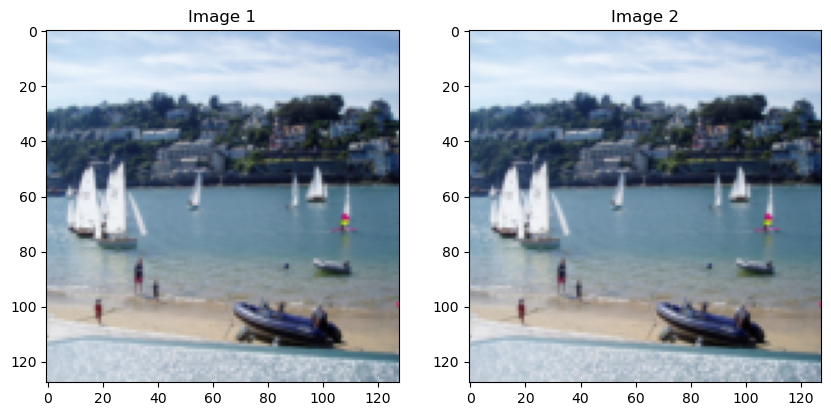

In [14]:
input_encoder_style = training_data_list[38]['image']

## plot reference style
plot_both(input_encoder_style.permute(1,2,0).numpy(),input_encoder_style.permute(1,2,0).numpy())

torch.Size([3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


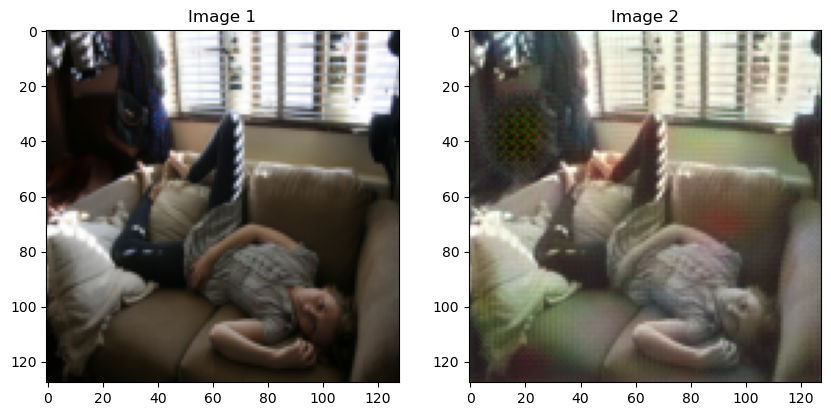

In [16]:
## style is the image itself
entry = training_data_list[30]
input_unet = entry['grayscale_image']
input_encoder = entry['image']
print(input_encoder.shape)
output = model(input_unet.unsqueeze(0).to(device), style_encoder(input_encoder.unsqueeze(0).to(device)))
output = output.detach().cpu().squeeze(0)
plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


#### Changed style

In [ ]:
entry = training_data_list[32]
input_unet = entry['grayscale_image']
input_encoder = input_encoder_style
print(input_encoder.shape)
output = model(input_unet.unsqueeze(0).to(device), style_encoder(input_encoder.unsqueeze(0).to(device)))
output = output.detach().cpu().squeeze(0)
plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


In [ ]:
reference_style = training_data_list[39]['image']
plot_both(reference_style.permute(1,2,0).numpy(),reference_style.permute(1,2,0).numpy())


In [ ]:
model.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=10, lr=0.0001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path= 'experiment_results/LAB_100', save_name_prefix='/1000_training_')

In [ ]:
visualize(list(train_data)[32],model,lab=False)

### Colorization from LAB color space. 

Input is a HxW grayscale image (the l channel).
Output is 2xHxW representing the ab channels.

No std and mean normalization is used.

In [ ]:
TRAIN_SIZE = 600
VAL_SIZE = 150
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='LAB')
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

In [ ]:
model = UNet(in_C=1, out_C=2)

In [ ]:
model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                  epochs=55, 
                  lr=0.0001, 
                  loss_fn=nn.MSELoss(), 
                  optimizer=torch.optim.Adam, 
                  verbose=True, 
                  save_path= 'experiment_results/LAB_55ep_600', 
                  save_name_prefix='/1000_training_',
                  colorspace='LAB')

In [ ]:

visualize(list(train_data)[32],model,lab=True)

In [ ]:

visualize(list(train_data)[19],model,lab=True)

In [ ]:

visualize(list(train_data)[42],model,lab=True)

In [ ]:

visualize(list(train_data)[43],model,lab=True)

In [ ]:
## must have length 8!
images_to_visualize_indexes = [3,12,5,17,11,3,28,29]

visualization_images = get_visualization_images(images_to_visualize_indexes)
outputs = get_batch_outputs(visualization_images)
plot_grid(visualization_images, outputs)